In [24]:
import random

from sklearn.metrics import mean_squared_error
# Imports
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.python.ops.gen_nn_ops import LeakyRelu

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, LeakyReLU
from keras.optimizers import Adam


In [25]:
# Functions
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


def check_stationarity(series):
    adf_result = adfuller(series)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

from sklearn.preprocessing import MinMaxScaler
import numpy as np

def window_generator(data, feature_columns, target_column, input_size, output_size, stride):

    X = []
    y = []

    data = data.sort_index()

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    scaled_features = feature_scaler.fit_transform(data[feature_columns])
    scaled_target = target_scaler.fit_transform(data[target_column])

    for start in range(0, len(data) - input_size - output_size + 1, stride):
        end_input = start + input_size
        end_output = end_input + output_size

        X.append(scaled_features[start:end_input])
        y.append(scaled_target[end_input:end_output])

    return np.array(X), np.array(y), feature_scaler, target_scaler



def test_window_generator(test_data, feature_columns, target_column, input_size, output_size, stride, feature_scaler, target_scaler):
    X_test = []
    y_test = []

    test_data = test_data.sort_index()

    scaled_features = feature_scaler.transform(test_data[feature_columns])
    scaled_target = target_scaler.transform(test_data[target_column])

    for start in range(0, len(test_data) - input_size - output_size + 1, stride):
        end_input = start + input_size
        end_output = end_input + output_size

        X_test.append(scaled_features[start:end_input])
        y_test.append(scaled_target[end_input:end_output])

    return np.array(X_test), np.array(y_test)



In [26]:


model = Sequential([
    Input(shape=(14, 882)),  # Match input shape with your data
    LSTM(50 , activation='tanh', return_sequences=True),
    Dropout(0.2),  # Regularization
    # First LSTM layer
    LSTM(25, activation='tanh', return_sequences=True),
    Dropout(0.2),  # Regularization

    # Second LSTM layer
    LSTM(10, activation='tanh', return_sequences=False),
    Dropout(0.2),  # Regularization

    # Fully connected output layer
    Dense(2, activation='linear')  # Output layer for 2 features
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 14, 50)         │       186,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 14, 25)         │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 10)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,662 (764.30 KB)

 Trainable params: 195,662 (764.30 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
ticker_data.columns

Index(['Volume_A', 'Volume_AAL', 'Volume_AAPL', 'Volume_ABT', 'Volume_ACGL',
       'Volume_ACN', 'Volume_ADBE', 'Volume_ADI', 'Volume_ADM', 'Volume_ADP',
       ...
       'Price_Change_WTW', 'Price_Change_WY', 'Price_Change_WYNN',
       'Price_Change_XEL', 'Price_Change_XOM', 'Price_Change_XRAY',
       'Price_Change_YUM', 'Price_Change_ZBH', 'Price_Change_ZBRA',
       'Price_Change_ZION'],
      dtype='object', length=882)

In [28]:

ticker_data = pd.read_csv('ticker_data.csv')
ticker_data['Date'] = pd.to_datetime(ticker_data['Unnamed: 0'])  # Ensure 'Date' is in datetime format
ticker_data.set_index('Date', inplace=True)
ticker_data.drop('Unnamed: 0', axis=1, inplace=True)
# Example column names
columns = ticker_data.columns.to_list()

# Extract unique tickers from column names
tickers = list(set(col.split('_')[1] for col in columns))

random_tickers = random.sample(tickers, 2)

X_columns = [f"Volume_{ticker}" for ticker in columns] + [f"Price_Change_{ticker}" for ticker in columns]
y_columns = [f"Price_Change_{ticker}" for ticker in random_tickers]

ticker_data.index = pd.to_datetime(ticker_data.index)

train_data = ticker_data.loc['2010-01-01':'2018-01-01']
test_data = ticker_data.loc['2018-01-01':'2020-01-01']
X_train, y_train , feature_scaler, target_scaler = window_generator(train_data, columns, y_columns, 60, 1, 1)
X_test , y_test = test_window_generator(test_data, columns, y_columns, 60, 1, 1, feature_scaler, target_scaler)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1718, 60, 882), (1718, 1, 2), (443, 60, 882), (443, 1, 2))

In [29]:
from keras.src.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - MAE: 0.2104 - loss: 0.0921 - val_MAE: 0.0522 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - MAE: 0.1221 - loss: 0.0251 - val_MAE: 0.0492 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - MAE: 0.1148 - loss: 0.0215 - val_MAE: 0.0535 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - MAE: 0.1064 - loss: 0.0187 - val_MAE: 0.0511 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - MAE: 0.1105 - loss: 0.0202 - val_MAE: 0.0521 - val_loss: 0.0053 - learning_rate: 5.0000e-04
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - MAE: 0.1085 - loss: 0.0198 - val_MAE: 0.0501 - val_loss: 0.0051 - learning_rate: 5.0000e-04
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - MAE: 0.1065 - loss: 0.0189 - val_MAE: 0.0505 - val_loss: 0.0051 - learning_rate: 2.5000e-04
E

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Mean Squared Error: 0.00026464994211961213


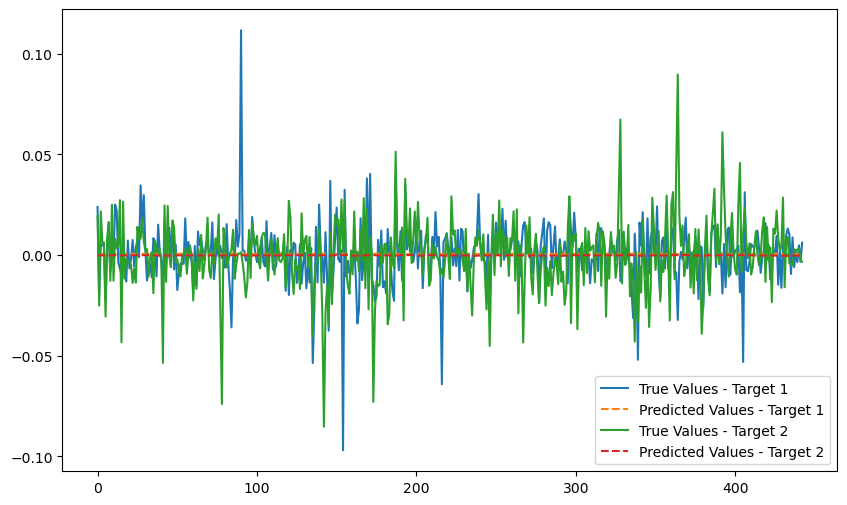

In [30]:
# Predicting y_test
y_pred = model.predict(X_test)

# Reshape y_test to match y_pred if needed
y_test_reshaped = y_test.reshape(y_test.shape[0], -1)  # Flatten to (473, 2)

# Inverse transform predictions and ground truth
y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test_reshaped)

# Evaluate results (e.g., using Mean Squared Error)
from sklearn.metrics import mean_squared_error

# Flatten both arrays for MSE if they are still multidimensional
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
print(f"Mean Squared Error: {mse}")

# Optionally, visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(y_test_original.shape[1]):  # Iterate over target columns
    plt.plot(y_test_original[:, i], label=f'True Values - Target {i + 1}')
    plt.plot(y_pred_original[:, i], label=f'Predicted Values - Target {i + 1}', linestyle='dashed')
plt.legend()
plt.show()

predictions_df = pd.DataFrame(y_pred_original, columns=["Ticker 0", "Ticker 1"])
targets_df = pd.DataFrame(y_test_original, columns=["Ticker 0", "Ticker 1"])



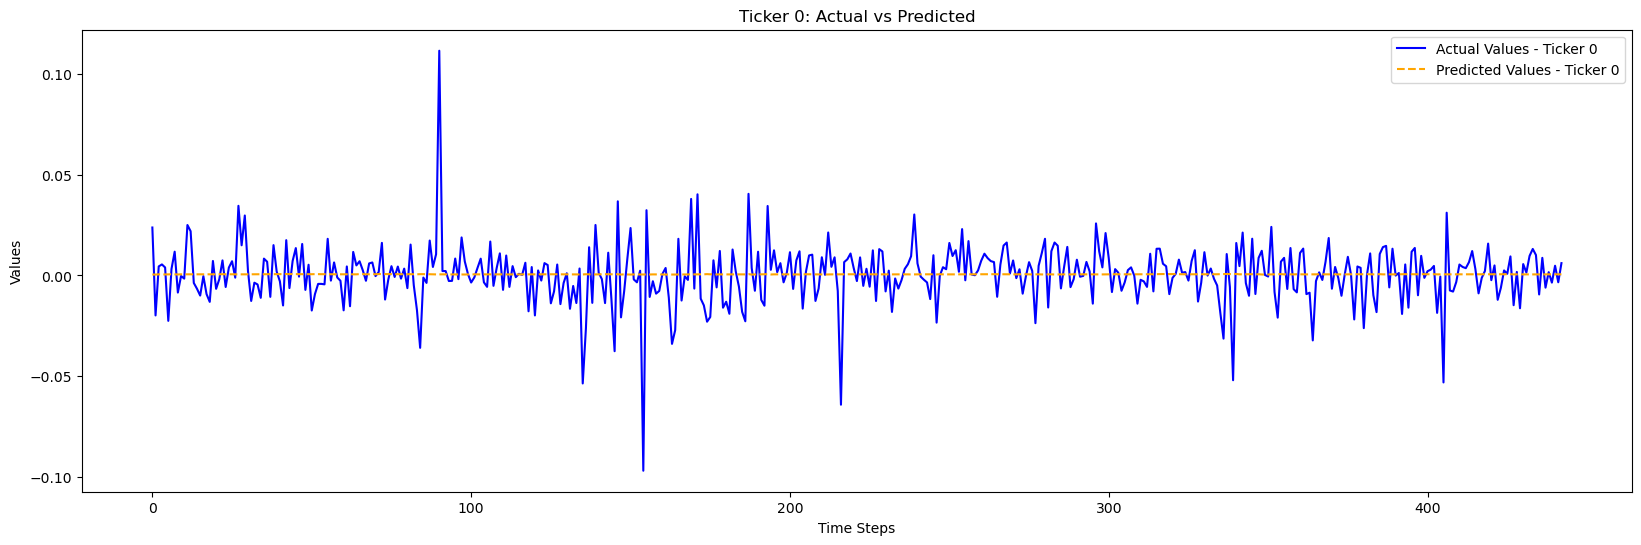

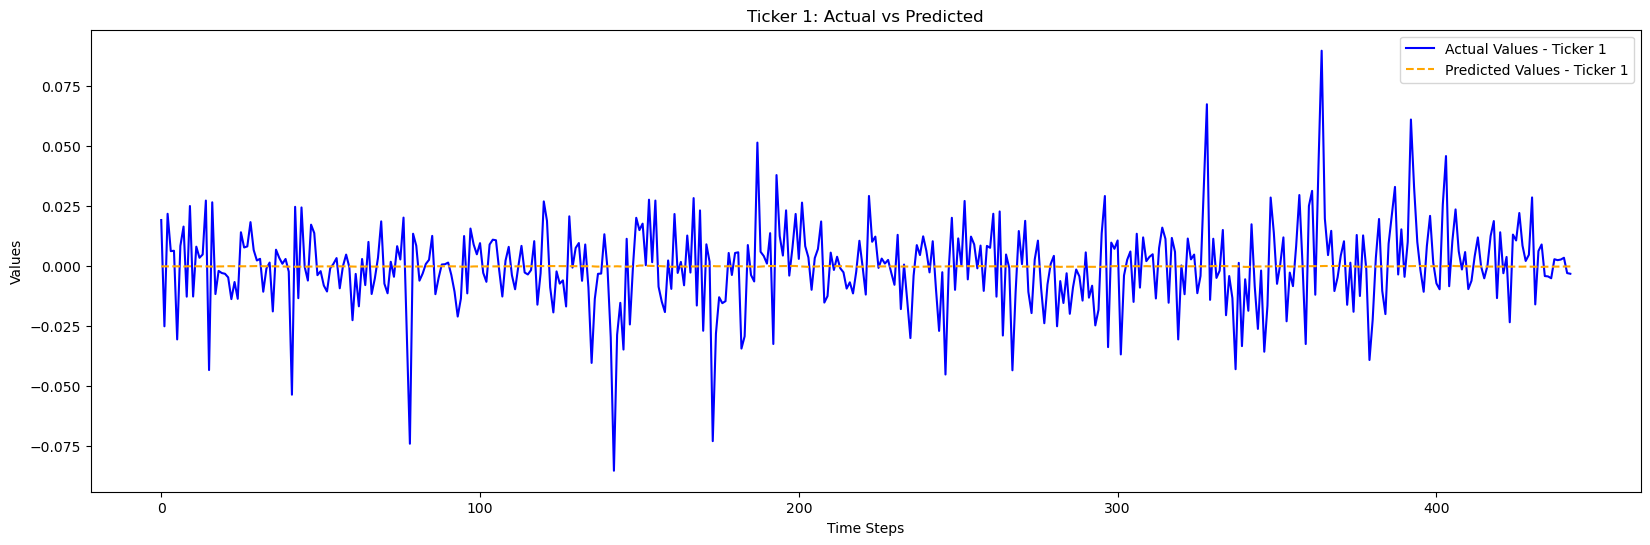

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions and targets to DataFrames if not already
predictions_df = pd.DataFrame(y_pred_original, columns=["Ticker 0", "Ticker 1"])
targets_df = pd.DataFrame(y_test_original, columns=["Ticker 0", "Ticker 1"])

# Plot for Ticker 0
plt.figure(figsize=(20, 6))
plt.plot(targets_df["Ticker 0"], label="Actual Values - Ticker 0", color="blue")
plt.plot(predictions_df["Ticker 0"], label="Predicted Values - Ticker 0", linestyle="dashed", color="orange")
plt.title("Ticker 0: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.show()

# Plot for Ticker 1
plt.figure(figsize=(20, 6))
plt.plot(targets_df["Ticker 1"], label="Actual Values - Ticker 1", color="blue")
plt.plot(predictions_df["Ticker 1"], label="Predicted Values - Ticker 1", linestyle="dashed", color="orange")
plt.title("Ticker 1: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.show()


In [32]:
y_pred_original

array([[ 4.57722083e-04, -2.35085899e-04],
       [ 4.17674542e-04, -1.81457974e-04],
       [ 5.42448601e-04, -2.01350413e-04],
       [ 4.49897285e-04, -2.04659635e-04],
       [ 4.82733274e-04, -1.87204263e-04],
       [ 4.74823872e-04, -1.68734492e-04],
       [ 5.62334899e-04, -2.21991286e-04],
       [ 4.97304369e-04, -2.59877212e-04],
       [ 4.78644652e-04, -1.73256063e-04],
       [ 5.49660122e-04, -1.49318337e-04],
       [ 5.54270402e-04, -1.51767774e-04],
       [ 5.74896869e-04, -1.49856467e-04],
       [ 5.59529231e-04, -1.67590188e-04],
       [ 6.04581845e-04, -2.09960577e-04],
       [ 5.96482074e-04, -2.01771021e-04],
       [ 6.02685555e-04, -2.55869032e-04],
       [ 6.20788371e-04, -2.83023197e-04],
       [ 5.73254365e-04, -2.75421276e-04],
       [ 5.83194022e-04, -2.16430562e-04],
       [ 5.51908859e-04, -2.22164483e-04],
       [ 5.42899768e-04, -1.70472602e-04],
       [ 5.64752845e-04, -1.10931382e-04],
       [ 6.10602030e-04, -1.27273364e-04],
       [ 5.

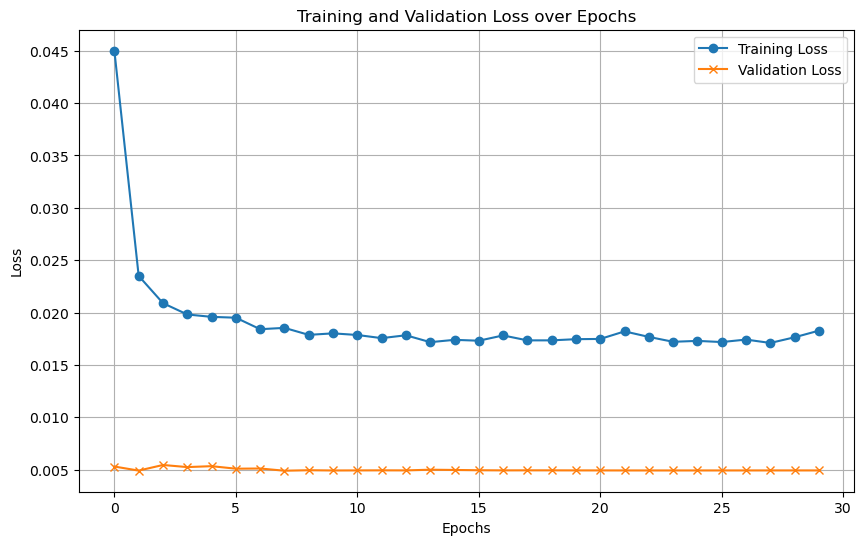

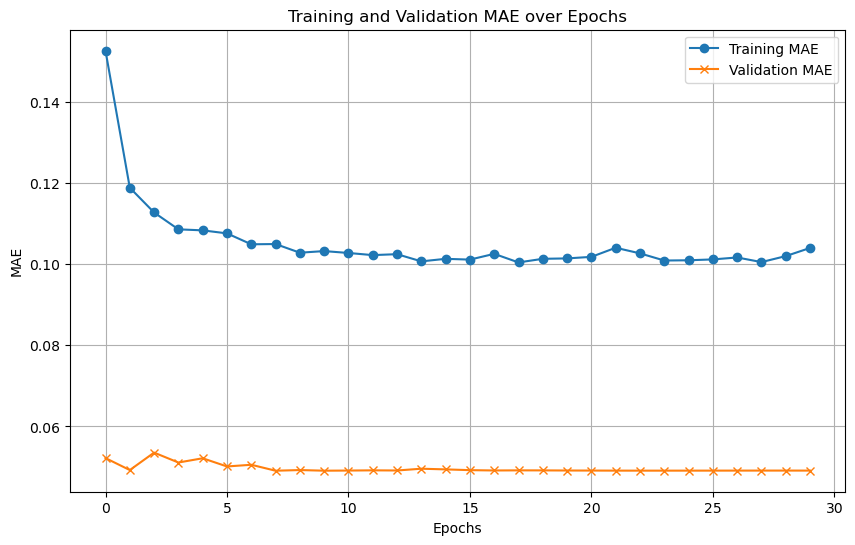

In [33]:

import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mape = history.history['MAE']
val_mape = history.history['val_MAE']

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAPE
plt.figure(figsize=(10, 6))
plt.plot(train_mape, label='Training MAE', marker='o')
plt.plot(val_mape, label='Validation MAE', marker='x')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Install TensorFlow and KerasTuner if not already installed
!pip install tensorflow keras-tuner

from keras_tuner import RandomSearch

# Define the model
def build_model(hp):
    model = Sequential([
        Input(shape=(14, 882)),
        LSTM(hp.Int('lstm_units1', min_value=50, max_value=150, step=50), activation='tanh', return_sequences=True),
        Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)),
        LSTM(hp.Int('lstm_units2', min_value=25, max_value=75, step=25), activation='tanh'),
        Dense(2, activation='linear')
    ])
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01])),
        loss='mean_squared_error',
        metrics=['MAE']
    )
    return model

# Ensure dataset compatibility
X_train = np.array(X_train)
y_train = np.array(y_train)

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=3)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=2, callbacks=[early_stopping])



# Debugging: List all trials
for trial_id, trial in tuner.oracle.trials.items():
    print(f"Trial ID: {trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Score: {trial.score}")

Trial ID: 00
Hyperparameters: {'learning_rate': 0.001}
Score: None
Trial ID: 01
Hyperparameters: {'learning_rate': 0.01}
Score: None


In [68]:
for trial_id, trial in tuner.oracle.trials.items():
    print(f"Trial ID: {trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Score: {trial.score}")

Trial ID: 00
Hyperparameters: {'learning_rate': 0.001}
Score: None
Trial ID: 01
Hyperparameters: {'learning_rate': 0.01}
Score: None
